In [3]:
from pylsl import StreamInlet, resolve_stream
import numpy as np
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import welch
import mne
from mne.decoding import Scaler

In [2]:
import torch
from torch import nn


In [4]:
class Block(nn.Module):
  def __init__(self,inplace):
    super().__init__()
    self.conv1=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=2,stride=2,padding=0)
    self.conv2=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=4,stride=2,padding=1)
    self.conv3=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=8,stride=2,padding=3)
    self.relu=nn.ReLU()

  def forward(self,x):
    x1=self.relu(self.conv1(x))
    # print("x1 :", x1.shape)
    x2=self.relu(self.conv2(x))
    # print("x2 :", x2.shape)
    x3=self.relu(self.conv3(x))
    # print("x3 :", x3.shape)
    x=torch.cat([x1,x2,x3],dim=1)
    return x

In [5]:
class ChronoNet(nn.Module):
  def __init__(self,channel):
    super().__init__()
    self.block1 = Block(channel)
    self.block2 = Block(96)
    self.block3 = Block(96)
    self.gru1 = nn.GRU(input_size=96, hidden_size=32, batch_first=True, dropout=0.1)  # Dropout added here
    self.gru2 = nn.GRU(input_size=32, hidden_size=32, batch_first=True, dropout=0.1)  # Dropout added here
    self.gru3 = nn.GRU(input_size=64, hidden_size=32, batch_first=True, dropout=0.1)  # Dropout added here
    self.gru4 = nn.GRU(input_size=96, hidden_size=32, batch_first=True, dropout=0.1)  # Dropout added here
    self.gru_linear = nn.Linear(30, 1) # 37 / 312
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32, 3)
    self.relu = nn.ReLU()
  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    # print("Here : " , x.shape)

    x=x.permute(0,2,1)
    # print("Here : " , x.shape)
    gru_out1,_=self.gru1(x)
    gru_out2,_=self.gru2(gru_out1)
    gru_out=torch.cat([gru_out1,gru_out2],dim=2)
    gru_out3,_=self.gru3(gru_out)
    gru_out=torch.cat([gru_out1,gru_out2,gru_out3],dim=2)

    linear_out=self.relu(self.gru_linear(gru_out.permute(0,2,1)))

    gru_out4,_=self.gru4(linear_out.permute(0,2,1))
    x=self.flatten(gru_out4)
    x=self.fc1(x)
    return x

In [7]:
model_load = ChronoNet(3)
model_load.load_state_dict(torch.load('eeg_classify_model_V0.pth'))

<All keys matched successfully>

In [8]:
model_load.state_dict()

OrderedDict([('block1.conv1.weight',
              tensor([[[-0.1921, -0.2046],
                       [ 0.1130, -0.0689],
                       [ 0.2069,  0.0709]],
              
                      [[ 0.0475, -0.1394],
                       [-0.1952, -0.0655],
                       [-0.0058,  0.4236]],
              
                      [[ 0.1275,  0.1386],
                       [-0.3115,  0.1834],
                       [ 0.2263,  0.1573]],
              
                      [[ 0.0275,  0.0550],
                       [ 0.1029, -0.3142],
                       [ 0.1520, -0.2223]],
              
                      [[-0.3974,  0.1183],
                       [ 0.0415, -0.0915],
                       [ 0.2772, -0.3929]],
              
                      [[ 0.2530,  0.0351],
                       [ 0.1144,  0.3517],
                       [ 0.2496, -0.0077]],
              
                      [[-0.0572,  0.1144],
                       [-0.3393, -0.0633],
       

In [ ]:
# out=model_load(data)
# out = torch.softmax(out, dim=1).argmax(dim = 1) 
# 0,1,2   

In [26]:


# first resolve an EEG stream on the lab network
print("looking for an EEG stream...")
streams = resolve_stream()
print(streams)

data = []
time_count = 0.0
time_all = 0.0

# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs = 250.0
lowcut = 8.0
highcut = 30.0
 
channels = ['C3','Cz','C4']
epoch_10s = np.zeros(shape=(3,246))

info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= fs
)

#size 3,246

while True:
    # get a new sample (you can also omit the timestamp part if you're not
    # interested in it)
    sample, timestamp = inlet.pull_sample()

    if timestamp:
        data.append(sample[1:4])
        time_count += 1 * 0.004
        time_count = np.round(time_count ,3)
        time_all += 1 * 0.004
        # data2 = butter_bandpass_filter(data2, lowcut, highcut, fs, order=6)

        if time_count == 10.004:
            data = np.asarray(data)
            data = np.transpose(data)
            raw = mne.io.RawArray(data, info)
            filter = raw.copy().filter(l_freq=8.0, h_freq=30.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
            psd:np.ndarray = filter.copy().compute_psd(method='welch', fmax = 30)
            scaler = Scaler(scalings='mean')
            X_norm = scaler.fit_transform(psd.get_data())

            epoch_10s = np.delete(epoch_10s, slice(0,246), axis =1)
            epoch_10s = np.append(epoch_10s, X_norm[:,:,0], axis= 1)
            out=model_load(torch.tensor(epoch_10s.reshape(1,3,246), dtype=torch.float32))
            out = torch.softmax(out, dim=1)

            # print(timestamp, data, np.shape(data))
            # print(".......................Filter....................")
            # print(filter.get_data(), np.shape(filter.get_data()))
            # print(".......................X_norm........................")
            # print(X_norm[:,:,0], np.shape(X_norm[:,:,0]))
            # print(".......................epoch_10s........................")
            # print(epoch_10s, np.shape(epoch_10s))
            print(".......................Class output.......................")
            print(out)

            data = np.ndarray.tolist(data)
            data = []
            time_count = 0.0
        
        # if time_all > 10:
        #     break

looking for an EEG stream...
Creating RawArray with float64 data, n_channels=3, n_times=2501
    Range : 0 ... 2500 =      0.000 ...    10.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Effective window size : 8.192 (s)
.......................Class output.......................
tensor([[0.2543, 0.7385, 0.0073]], grad_fn=<SoftmaxBackward0>)
Creating RawArray with float64 data, n_channels=3, n_times=2501
    Range : 0 ... 2500 =      0.000 ...    10.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after f

KeyboardInterrupt: 

In [21]:
psd.get_data()

array([[2.84984944e+14, 2.50770429e+14, 1.62651966e+13, 1.69301717e+13,
        1.75672832e+13, 1.69312326e+13, 1.35813443e+13, 7.36342149e+13,
        4.48783587e+14, 9.21393850e+12, 1.16068965e+12, 8.37355410e+11,
        4.23513554e+12, 2.17369550e+12, 1.73788423e+11, 3.62174785e+11,
        5.75933723e+11, 2.77366648e+12, 1.01131456e+12, 4.53570146e+12,
        2.95438752e+11, 4.22943459e+12, 2.36439552e+12, 6.39055548e+12,
        2.55518955e+12, 9.21911030e+12, 8.05918559e+12, 7.34251420e+12,
        1.94328781e+13, 1.16059693e+13, 1.93236147e+13],
       [1.53573643e+14, 1.35132383e+14, 8.76447498e+12, 9.12281961e+12,
        9.46537022e+12, 9.12404944e+12, 7.33662857e+12, 3.95649494e+13,
        2.40877917e+14, 5.35058081e+12, 3.47750135e+11, 4.22714109e+11,
        1.47051688e+12, 6.26226143e+11, 5.38522199e+10, 2.73298292e+11,
        3.35718023e+11, 1.23812231e+12, 5.53567033e+11, 2.10041834e+12,
        2.80717666e+11, 2.03059363e+12, 1.29965843e+12, 3.03806374e+12,
       

In [22]:
X_norm

array([[[ 1.31266439],
        [ 1.3126699 ],
        [ 1.31266857],
        [ 1.31265042],
        [ 1.31260333],
        [ 1.31252705],
        [ 1.30961048],
        [ 1.32549023],
        [ 1.30470061],
        [ 1.31237154],
        [ 1.36574107],
        [ 1.35996133],
        [ 1.38361609],
        [ 1.41225369],
        [ 0.54213471],
        [ 0.99571002],
        [ 1.30487117],
        [ 1.41276681],
        [ 1.29830634],
        [ 1.33741502],
        [ 0.79852431],
        [ 1.40578868],
        [ 1.27237869],
        [ 1.33561063],
        [ 1.35329834],
        [ 1.33244554],
        [ 1.36167201],
        [ 1.23210337],
        [ 1.31472954],
        [ 1.31418407],
        [ 1.32231511]],

       [[-0.20060842],
        [-0.20062308],
        [-0.20061955],
        [-0.20057127],
        [-0.20044602],
        [-0.20024318],
        [-0.19253877],
        [-0.23577119],
        [-0.17978576],
        [-0.19982987],
        [-0.36496569],
        [-0.34400614],
        [

C:\Users\pipo_\AppData\Local\Temp\ipykernel_6048\561091968.py:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  psd.plot()
C:\Users\pipo_\AppData\Local\Temp\ipykernel_6048\561091968.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()
C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


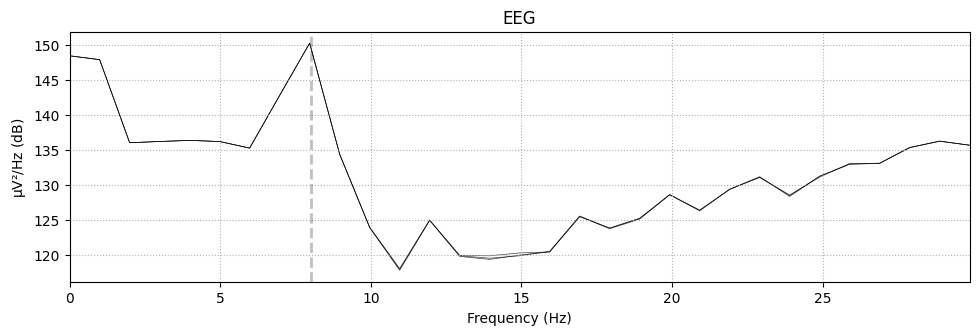

In [25]:
psd.plot()

In [26]:
np.shape(psd.get_data())

(3, 31)